In [23]:
import pandas as pd
from utility_functions import cross_validate_and_save_model, vectorize, evaluate,get_confused_samples
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import matplotlib.pyplot as plt
import random
plt.style.use('dark_background')

# Modify Data
create a modified version of the data that is more balanced and has less samples that are tagged as "no topic"

In [24]:
df = pd.read_csv(f'../data/6 - Classification data/full_classification_df.csv')

df.dropna(subset=['NonStopwordsQuoteText'],inplace=True)
print("total number of samples:",df.shape[0])
print(df['Tag'].value_counts())

total number of samples: 2367
בלי           1035
חינוך          214
קורונה         211
רווחה          191
כלכלי          186
נשים           168
בריאות         161
בטחון פנים     102
בטחון           99
Name: Tag, dtype: int64


In [25]:
df = df.sort_values(by=['Tag']).reset_index(drop=True)
first = df['Tag'].gt("בלי").idxmax()
no_topic_lst = df.index[df['Tag']=="בלי"].tolist()

# drop most samples that are tagged as "no topic" (leave only 200)
first, last = no_topic_lst[0], no_topic_lst[-1]
keep_range = random.sample(range(first, last), 250)
keep_range.extend(range(0,first))
keep_range.extend(range(last + 1, len(df)))

df = df.iloc[keep_range].reset_index(drop=True)
print(df['Tag'].value_counts())
print("total number of samples:",df.shape[0])
df = df.sample(frac=1).reset_index(drop=True)
df.head()

בלי           250
חינוך         214
קורונה        211
רווחה         191
כלכלי         186
נשים          168
בריאות        161
בטחון פנים    102
בטחון          99
Name: Tag, dtype: int64
total number of samples: 1582


,Type,QuoteWordCount,QuoteLen,StartDate,Speaker,QuoteText,NonStopwordsQuoteText,Tag
0,Committee,89.0,518.0,2021-10-03 11:00:00,"<< יור >> היו""ר עידית סילמן: << יור >>",זהו דיון ראשון במסגרת סדרת דיונים בנושא מערך ה...,זהו במסגרת סדרת דיונים מערך הבטחון התזונתי בנו...,בריאות
1,Committee,107.0,590.0,2020-10-26 10:15:00,"<< דובר >> עידן רול (יש עתיד-תל""ם): << דובר >>","דבר שני: מסעדות הן מטבען עסק בסיכון, ודאי מסעד...",מסעדות מטבען עסק בסיכון ודאי מסעדות שרק פתחו ו...,כלכלי
2,Committee,61.0,313.0,2017-03-22 10:00:00,"היו""ר מכלוף מיקי זוהר:","אני אמרתי את זה בלא מעט הזדמנויות, שאנחנו רוצי...",אמרתי בלא הזדמנויות לאפשר שרוצה ממדינת לשרת מו...,בטחון
3,Committee,115.0,585.0,2017-03-20 11:00:00,"היו""ר מכלוף מיקי זוהר:","אני לא יודע אם אתם יודעים, אבל נתונים מעניינים...",נתונים מעניינים שבעה גברים עבר פגיעה מינית בחי...,נשים
4,Committee,17.0,100.0,2016-12-05 21:45:00,"היו""ר יואב קיש:","אנחנו דנים בנושא של ועדה משותפת לוועדת החוקה, ...",דנים ועדה משותפת לוועדת החוקה ומשפט ולוועדת הח...,בלי


## Split data to train and test

In [26]:
X = df['QuoteText']
y = df['Tag']
names = ["X_train", "X_test", "y_train", "y_test"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for name, data in enumerate([X_train, X_test, y_train, y_test]):
    data.reset_index(drop=True, inplace=True)
    data.to_csv(f'../data/8 - Classification Data (phase 3)/{names[name]}.csv', index=0)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

print("Tags distribution:\n")
print("train tags\n", y_train.value_counts(), "\n")
print("test tags\n", y_test.value_counts())

Tags distribution:

train tags
 בלי           200
חינוך         174
קורונה        165
רווחה         154
כלכלי         146
נשים          134
בריאות        131
בטחון פנים     84
בטחון          77
Name: Tag, dtype: int64 

test tags
 בלי           50
קורונה        46
כלכלי         40
חינוך         40
רווחה         37
נשים          34
בריאות        30
בטחון         22
בטחון פנים    18
Name: Tag, dtype: int64


## Vectorize data

In [27]:
X_train_counts, X_test_counts = vectorize(X_train, X_test,"simple_counts")
X_train_tfidf, X_test_tfidf = vectorize(X_train, X_test,"tfidf")

simple counts: 1265 quotes, 51031 words in train set
TFIDF: 1265 quotes, 51031 words in train set


# Classificaiton models
## Logistic Regression
#### Logistic Regression with simple counts

In [28]:
logistic_simple_model, logistic_simple_predicted = cross_validate_and_save_model(LogisticRegression(), X_train_counts, y_train, X_test_counts, kf, scoring, 'logistic_simple_counts',3)

cross validation scores (5fold) for logistic_simple_counts:
accuracy: 0.5517786561264822
precision_macro: 0.6970649946496866
recall_macro: 0.5128168495241355
f1_macro: 0.5508002339099687


In [29]:
logistic_c2_simple_model, logistic_c2_simple_predicted = cross_validate_and_save_model(LogisticRegression(C=2), X_train_counts, y_train, X_test_counts, kf, scoring, 'logistic_c2_simple_counts',3)

cross validation scores (5fold) for logistic_c2_simple_counts:
accuracy: 0.5549407114624506
precision_macro: 0.6917211093595048
recall_macro: 0.5159955071089233
f1_macro: 0.5516405700706046


In [30]:
logistic_c05_simple_model, logistic_c05_simple_predicted = cross_validate_and_save_model(LogisticRegression(C=0.5), X_train_counts, y_train, X_test_counts, kf, scoring, 'logistic_c05_simple_counts',3)

cross validation scores (5fold) for logistic_c05_simple_counts:
accuracy: 0.5430830039525693
precision_macro: 0.690819861780447
recall_macro: 0.5012935881427999
f1_macro: 0.5376802255582641


#### Logistic Regression with TFIDF

In [31]:
logistic_tfidf_model, logistic_tfidf_predicted = cross_validate_and_save_model(LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'logistic_tfidf_counts',3)

cross validation scores (5fold) for logistic_tfidf_counts:
accuracy: 0.4782608695652174
precision_macro: 0.6524257097070316
recall_macro: 0.41460346823197713
f1_macro: 0.4421890498261997


In [32]:
logistic_c05_tfidf_model, logistic_c05_tfidf_predicted = cross_validate_and_save_model(LogisticRegression(C=0.5), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'logistic_c05_tfidf_counts',3)

cross validation scores (5fold) for logistic_c05_tfidf_counts:
accuracy: 0.43478260869565216
precision_macro: 0.5901360959728208
recall_macro: 0.3678850562785479
f1_macro: 0.3857644323904189


## Random Forest
#### Random forest with simple counts

In [33]:
forest_30_100_simple_model, forest_30_100_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=30, max_depth=100), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_30_100_simple_counts',3)

cross validation scores (5fold) for forest_30_100_simple_counts:
accuracy: 0.5415019762845851
precision_macro: 0.6752874178893229
recall_macro: 0.5009251216019052
f1_macro: 0.5340986957149765


In [34]:
forest_100_100_simple_model, forest_100_100_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=100), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_100_100_simple_counts',3)

cross validation scores (5fold) for forest_100_100_simple_counts:
accuracy: 0.5501976284584981
precision_macro: 0.6989239437094039
recall_macro: 0.5051589888172964
f1_macro: 0.5350080656130027


In [35]:
forest_200_100_simple_model, forest_200_100_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=200, max_depth=100), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_200_100_simple_counts',3)

cross validation scores (5fold) for forest_200_100_simple_counts:
accuracy: 0.5604743083003954
precision_macro: 0.7119850960770069
recall_macro: 0.5193675835591566
f1_macro: 0.5546520795732539


In [36]:
forest_100_200_simple_model, forest_100_200_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=200), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_100_200_simple_counts',3)

cross validation scores (5fold) for forest_100_200_simple_counts:
accuracy: 0.5201581027667985
precision_macro: 0.7109165661164264
recall_macro: 0.47186998072633496
f1_macro: 0.5082738910317184


In [37]:
forest_100_1000_simple_model, forest_100_1000_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=1000), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_100_1000_simple_counts',3)

cross validation scores (5fold) for forest_100_1000_simple_counts:
accuracy: 0.5027667984189724
precision_macro: 0.7510092615606015
recall_macro: 0.4503071090058285
f1_macro: 0.48293123315652675


In [38]:
forest_150_1000_simple_model, forest_150_1000_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=150, max_depth=1000), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_150_1000_simple_counts',3)

cross validation scores (5fold) for forest_150_1000_simple_counts:
accuracy: 0.49011857707509876
precision_macro: 0.7135280048491296
recall_macro: 0.43918583708206277
f1_macro: 0.4688394321359201


#### Random forest with TFIDF

In [39]:
forest_100_200_tfidf_model, forest_100_200_tfidf_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=200), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'forest_100_200_tfidf_counts',3)

cross validation scores (5fold) for forest_100_200_tfidf_counts:
accuracy: 0.5288537549407114
precision_macro: 0.7140629644229143
recall_macro: 0.4842311559372655
f1_macro: 0.5191968383641881


In [40]:
forest_100_1000_tfidf_model, forest_100_1000_tfidf_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=1000), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'forest_100_1000_tfidf_counts',3)

cross validation scores (5fold) for forest_100_1000_tfidf_counts:
accuracy: 0.49644268774703554
precision_macro: 0.7285399993671541
recall_macro: 0.4453615906615586
f1_macro: 0.48144683158563073


## SVM
#### SVM with simple counts

In [41]:
svm_simple_model, svm_simple_predicted = cross_validate_and_save_model(svm.SVC(), X_train_counts, y_train, X_test_counts, kf, scoring, 'svm_simple_counts',3)

cross validation scores (5fold) for svm_simple_counts:
accuracy: 0.4000000000000001
precision_macro: 0.5782712458249903
recall_macro: 0.34201069562509206
f1_macro: 0.35301802930554815


#### SVM with TFIDF

In [42]:
svm_tfidf_model, svm_tfidf_predicted = cross_validate_and_save_model(svm.SVC(), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'svm_tfidf_counts',3)

cross validation scores (5fold) for svm_tfidf_counts:
accuracy: 0.38893280632411065
precision_macro: 0.6724648349281442
recall_macro: 0.3265523642000373
f1_macro: 0.3457536410518921


# Evaluation

In [43]:
quotes = X_test.reset_index()
quotes['true'] = y_test
mat_tags = ['בטחון','בטחון פנים','בלי','בריאות','חינוך','כלכלי','נשים','קורונה','רווחה']
quotes

,index,QuoteText,true
0,0,"בוקר טוב. היום ה-11 בפברואר 2018, כ""ו בשבט התש...",בריאות
1,1,אני פותחת את הוועדה לקידום מעמד האישה ולשוויון...,נשים
2,2,"בשנת 2016 נקלטו במקלט מעגן, שזה מקלט לניצולות ...",נשים
3,3,"בוקר טוב לכולן, בוקר טוב לכולם. אני פותחת את ה...",נשים
4,4,אני רוצה להצביע על חבריי בליכוד שכל הזמן בוכים...,בלי
...,...,...,...
312,312,"חברי הכנסת, אני מתכבד לפתוח את ישיבת ועדת הכנס...",קורונה
313,313,"שלום לכולם, אני מתכבד לפתוח את ישיבת ועדת החינ...",חינוך
314,314,אנחנו רואים באמת שאין מספיק פתרונות לאוכלוסיות...,חינוך
315,315,"הבת, שמה לינדה, היא נפגעה, הייתה יומיים בטיפול...",בטחון פנים


## Logistic regression

-------Logistic Regression simple counts, C=1) Evaluation-------
Micro:
precision: 0.5678233438485805
recall: 0.5678233438485805
f1: 0.5678233438485805

Macro:
precision: 0.702241582408463
recall: 0.5161309585180003
f1: 0.5552342473895198

Accuracy: 0.5678233438485805

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 96 of 137 (70.07299270072993%)

Distribution of misclassified topics:
בלי           96
רווחה         13
כלכלי         11
בריאות         8
חינוך          3
בטחון          2
קורונה         2
בטחון פנים     1
נשים           1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
0,0,"בוקר טוב. היום ה-11 בפברואר 2018, כ""ו בשבט התש...",בריאות,רווחה
6,6,"כן, אבל זה רק מעלה את השאלה האם בכלל החוק הזה ...",רווחה,בלי
13,13,ביום הזה כולנו עם המשפחה שנטבחה בחלמיש ואנחנו ...,בטחון,בלי
14,14,"מכובדיי, צוהריים טובים לכולם. אני מתנצל על האי...",כלכלי,בלי
16,16,אנחנו רוצים לשמוע את הממצאים הראשונים כתוצאה ש...,בטחון פנים,בלי
...,...,...,...,...
309,309,אהלן. אני שמח לפתוח את ישיבת ועדת המשנה של ועד...,בלי,חינוך
311,311,אנחנו עוברים לסעיף האחרון בסדר היום. על סדר הי...,בטחון,בלי
314,314,אנחנו רואים באמת שאין מספיק פתרונות לאוכלוסיות...,חינוך,רווחה
315,315,"הבת, שמה לינדה, היא נפגעה, הייתה יומיים בטיפול...",בטחון פנים,רווחה


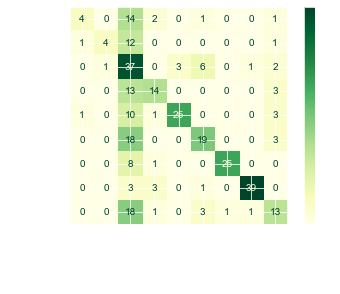

In [44]:
evaluate("-------Logistic Regression simple counts, C=1) Evaluation-------",y_test,logistic_simple_predicted,mat_tags)
get_confused_samples(quotes,logistic_simple_predicted)

-------Logistic Regression simple counts, C=2) Evaluation-------
Micro:
precision: 0.5646687697160884
recall: 0.5646687697160884
f1: 0.5646687697160884

Macro:
precision: 0.695973067803267
recall: 0.5139087362957782
f1: 0.5522870752346472

Accuracy: 0.5646687697160884

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 95 of 138 (68.84057971014492%)

Distribution of misclassified topics:
בלי           95
רווחה         13
כלכלי         11
בריאות        10
חינוך          3
בטחון          2
קורונה         2
בטחון פנים     1
נשים           1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
0,0,"בוקר טוב. היום ה-11 בפברואר 2018, כ""ו בשבט התש...",בריאות,רווחה
6,6,"כן, אבל זה רק מעלה את השאלה האם בכלל החוק הזה ...",רווחה,בלי
13,13,ביום הזה כולנו עם המשפחה שנטבחה בחלמיש ואנחנו ...,בטחון,בלי
14,14,"מכובדיי, צוהריים טובים לכולם. אני מתנצל על האי...",כלכלי,בלי
16,16,אנחנו רוצים לשמוע את הממצאים הראשונים כתוצאה ש...,בטחון פנים,בלי
...,...,...,...,...
309,309,אהלן. אני שמח לפתוח את ישיבת ועדת המשנה של ועד...,בלי,חינוך
311,311,אנחנו עוברים לסעיף האחרון בסדר היום. על סדר הי...,בטחון,בלי
314,314,אנחנו רואים באמת שאין מספיק פתרונות לאוכלוסיות...,חינוך,רווחה
315,315,"הבת, שמה לינדה, היא נפגעה, הייתה יומיים בטיפול...",בטחון פנים,רווחה


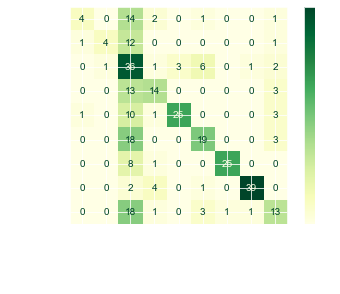

In [45]:
evaluate("-------Logistic Regression simple counts, C=2) Evaluation-------",y_test,logistic_c2_simple_predicted,mat_tags)
get_confused_samples(quotes,logistic_c2_simple_predicted)

-------Logistic Regression simple counts, C=0.5) Evaluation-------
Micro:
precision: 0.5741324921135647
recall: 0.5741324921135647
f1: 0.5741324921135647

Macro:
precision: 0.7071720861693761
recall: 0.5218463798216568
f1: 0.5600995048745137

Accuracy: 0.5741324921135647

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 95 of 135 (70.37037037037037%)

Distribution of misclassified topics:
בלי           95
רווחה         12
כלכלי         12
בריאות         7
חינוך          3
בטחון          2
קורונה         2
בטחון פנים     1
נשים           1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
0,0,"בוקר טוב. היום ה-11 בפברואר 2018, כ""ו בשבט התש...",בריאות,רווחה
6,6,"כן, אבל זה רק מעלה את השאלה האם בכלל החוק הזה ...",רווחה,בלי
13,13,ביום הזה כולנו עם המשפחה שנטבחה בחלמיש ואנחנו ...,בטחון,בלי
14,14,"מכובדיי, צוהריים טובים לכולם. אני מתנצל על האי...",כלכלי,בלי
16,16,אנחנו רוצים לשמוע את הממצאים הראשונים כתוצאה ש...,בטחון פנים,בלי
...,...,...,...,...
309,309,אהלן. אני שמח לפתוח את ישיבת ועדת המשנה של ועד...,בלי,חינוך
311,311,אנחנו עוברים לסעיף האחרון בסדר היום. על סדר הי...,בטחון,בלי
314,314,אנחנו רואים באמת שאין מספיק פתרונות לאוכלוסיות...,חינוך,רווחה
315,315,"הבת, שמה לינדה, היא נפגעה, הייתה יומיים בטיפול...",בטחון פנים,רווחה


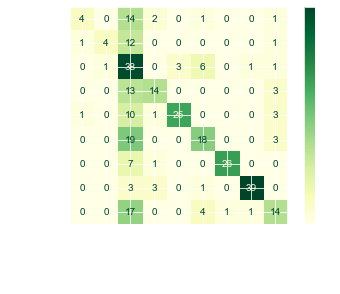

In [46]:
evaluate("-------Logistic Regression simple counts, C=0.5) Evaluation-------",y_test,logistic_c05_simple_predicted,mat_tags)
get_confused_samples(quotes,logistic_c05_simple_predicted)

-------Logistic Regression TFIDF counts, C=1) Evaluation-------
Micro:
precision: 0.5331230283911672
recall: 0.5331230283911672
f1: 0.5331230283911672

Macro:
precision: 0.6568799781360168
recall: 0.477466510143407
f1: 0.5033919600922214

Accuracy: 0.5331230283911672

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 105 of 148 (70.94594594594594%)

Distribution of misclassified topics:
בלי           105
רווחה          14
בריאות         10
כלכלי           6
קורונה          5
חינוך           5
בטחון פנים      1
בטחון           1
נשים            1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
0,0,"בוקר טוב. היום ה-11 בפברואר 2018, כ""ו בשבט התש...",בריאות,רווחה
6,6,"כן, אבל זה רק מעלה את השאלה האם בכלל החוק הזה ...",רווחה,בלי
11,11,המתווים האלה שאפשרו כניסת תיירים בוטלו לאחרונה...,קורונה,בלי
13,13,ביום הזה כולנו עם המשפחה שנטבחה בחלמיש ואנחנו ...,בטחון,בלי
14,14,"מכובדיי, צוהריים טובים לכולם. אני מתנצל על האי...",כלכלי,קורונה
...,...,...,...,...
309,309,אהלן. אני שמח לפתוח את ישיבת ועדת המשנה של ועד...,בלי,חינוך
311,311,אנחנו עוברים לסעיף האחרון בסדר היום. על סדר הי...,בטחון,בלי
314,314,אנחנו רואים באמת שאין מספיק פתרונות לאוכלוסיות...,חינוך,רווחה
315,315,"הבת, שמה לינדה, היא נפגעה, הייתה יומיים בטיפול...",בטחון פנים,רווחה


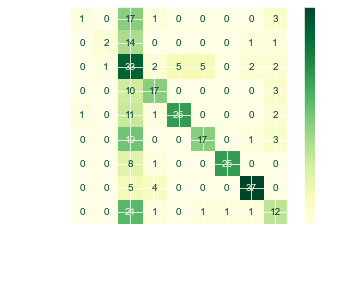

In [47]:
evaluate("-------Logistic Regression TFIDF counts, C=1) Evaluation-------",y_test,logistic_tfidf_predicted,mat_tags)
get_confused_samples(quotes,logistic_tfidf_predicted)

-------Logistic Regression TFIDF counts, C=0.5) Evaluation-------
Micro:
precision: 0.4952681388012618
recall: 0.4952681388012618
f1: 0.4952681388012618

Macro:
precision: 0.6676717252683005
recall: 0.4304068347972867
f1: 0.461204744345155

Accuracy: 0.4952681388012618

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 137 of 160 (85.625%)

Distribution of misclassified topics:
בלי       137
רווחה       8
חינוך       5
בריאות      4
כלכלי       3
קורונה      2
נשים        1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
0,0,"בוקר טוב. היום ה-11 בפברואר 2018, כ""ו בשבט התש...",בריאות,רווחה
6,6,"כן, אבל זה רק מעלה את השאלה האם בכלל החוק הזה ...",רווחה,בלי
11,11,המתווים האלה שאפשרו כניסת תיירים בוטלו לאחרונה...,קורונה,בלי
13,13,ביום הזה כולנו עם המשפחה שנטבחה בחלמיש ואנחנו ...,בטחון,בלי
14,14,"מכובדיי, צוהריים טובים לכולם. אני מתנצל על האי...",כלכלי,קורונה
...,...,...,...,...
309,309,אהלן. אני שמח לפתוח את ישיבת ועדת המשנה של ועד...,בלי,חינוך
311,311,אנחנו עוברים לסעיף האחרון בסדר היום. על סדר הי...,בטחון,בלי
314,314,אנחנו רואים באמת שאין מספיק פתרונות לאוכלוסיות...,חינוך,בלי
315,315,"הבת, שמה לינדה, היא נפגעה, הייתה יומיים בטיפול...",בטחון פנים,רווחה


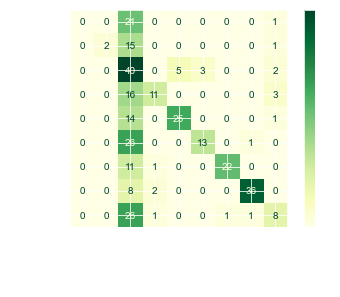

In [48]:
evaluate("-------Logistic Regression TFIDF counts, C=0.5) Evaluation-------",y_test,logistic_c05_tfidf_predicted,mat_tags)
get_confused_samples(quotes,logistic_c05_tfidf_predicted)

## Random forest

-----Random forest with simple counts, 100 trees, max depth 200) Evaluation-----
Micro:
precision: 0.5331230283911672
recall: 0.5331230283911672
f1: 0.5331230283911672

Macro:
precision: 0.6725013312372975
recall: 0.4790232583199335
f1: 0.5062976369472598

Accuracy: 0.5331230283911672

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 117 of 148 (79.05405405405406%)

Distribution of misclassified topics:
בלי           117
בריאות          6
כלכלי           6
קורונה          5
חינוך           5
רווחה           3
בטחון           3
בטחון פנים      2
נשים            1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
0,0,"בוקר טוב. היום ה-11 בפברואר 2018, כ""ו בשבט התש...",בריאות,בלי
6,6,"כן, אבל זה רק מעלה את השאלה האם בכלל החוק הזה ...",רווחה,בלי
13,13,ביום הזה כולנו עם המשפחה שנטבחה בחלמיש ואנחנו ...,בטחון,בלי
14,14,"מכובדיי, צוהריים טובים לכולם. אני מתנצל על האי...",כלכלי,קורונה
16,16,אנחנו רוצים לשמוע את הממצאים הראשונים כתוצאה ש...,בטחון פנים,בלי
...,...,...,...,...
309,309,אהלן. אני שמח לפתוח את ישיבת ועדת המשנה של ועד...,בלי,חינוך
311,311,אנחנו עוברים לסעיף האחרון בסדר היום. על סדר הי...,בטחון,בלי
314,314,אנחנו רואים באמת שאין מספיק פתרונות לאוכלוסיות...,חינוך,בלי
315,315,"הבת, שמה לינדה, היא נפגעה, הייתה יומיים בטיפול...",בטחון פנים,רווחה


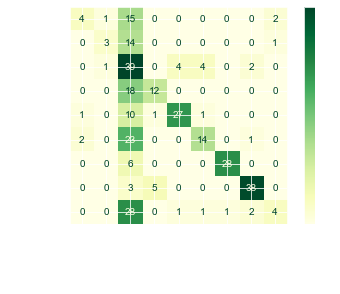

In [49]:
evaluate("-----Random forest with simple counts, 100 trees, max depth 200) Evaluation-----",y_test,forest_100_200_simple_predicted,mat_tags)
get_confused_samples(quotes,forest_100_200_simple_predicted)

-----Random forest with simple counts, 100 trees, max depth 1000) Evaluation-----
Micro:
precision: 0.5299684542586751
recall: 0.5299684542586751
f1: 0.5299684542586751

Macro:
precision: 0.70200227190453
recall: 0.477381911090351
f1: 0.5074644873558966

Accuracy: 0.5299684542586751

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 122 of 149 (81.87919463087249%)

Distribution of misclassified topics:
בלי           122
בריאות          7
קורונה          5
חינוך           4
כלכלי           4
רווחה           3
בטחון           2
בטחון פנים      1
נשים            1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
0,0,"בוקר טוב. היום ה-11 בפברואר 2018, כ""ו בשבט התש...",בריאות,בלי
6,6,"כן, אבל זה רק מעלה את השאלה האם בכלל החוק הזה ...",רווחה,בלי
13,13,ביום הזה כולנו עם המשפחה שנטבחה בחלמיש ואנחנו ...,בטחון,בלי
14,14,"מכובדיי, צוהריים טובים לכולם. אני מתנצל על האי...",כלכלי,קורונה
16,16,אנחנו רוצים לשמוע את הממצאים הראשונים כתוצאה ש...,בטחון פנים,בלי
...,...,...,...,...
309,309,אהלן. אני שמח לפתוח את ישיבת ועדת המשנה של ועד...,בלי,חינוך
311,311,אנחנו עוברים לסעיף האחרון בסדר היום. על סדר הי...,בטחון,בלי
314,314,אנחנו רואים באמת שאין מספיק פתרונות לאוכלוסיות...,חינוך,בלי
315,315,"הבת, שמה לינדה, היא נפגעה, הייתה יומיים בטיפול...",בטחון פנים,רווחה


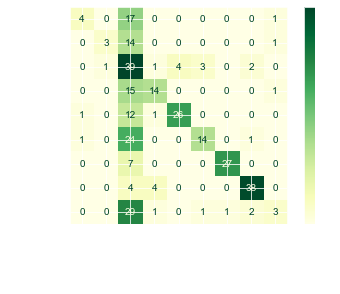

In [50]:
evaluate("-----Random forest with simple counts, 100 trees, max depth 1000) Evaluation-----",y_test,forest_100_1000_simple_predicted,mat_tags)
get_confused_samples(quotes,forest_100_1000_simple_predicted)

-----Random forest with simple counts, 150 trees, max depth 1000) Evaluation-----
Micro:
precision: 0.5205047318611987
recall: 0.5205047318611987
f1: 0.5205047318611987

Macro:
precision: 0.6879759296589499
recall: 0.4680267631034895
f1: 0.5004642313572832

Accuracy: 0.5205047318611987

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 124 of 152 (81.57894736842105%)

Distribution of misclassified topics:
בלי           124
בריאות          7
קורונה          5
כלכלי           5
רווחה           3
חינוך           3
בטחון פנים      2
בטחון           2
נשים            1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
0,0,"בוקר טוב. היום ה-11 בפברואר 2018, כ""ו בשבט התש...",בריאות,בלי
6,6,"כן, אבל זה רק מעלה את השאלה האם בכלל החוק הזה ...",רווחה,בלי
13,13,ביום הזה כולנו עם המשפחה שנטבחה בחלמיש ואנחנו ...,בטחון,בלי
14,14,"מכובדיי, צוהריים טובים לכולם. אני מתנצל על האי...",כלכלי,קורונה
16,16,אנחנו רוצים לשמוע את הממצאים הראשונים כתוצאה ש...,בטחון פנים,בלי
...,...,...,...,...
309,309,אהלן. אני שמח לפתוח את ישיבת ועדת המשנה של ועד...,בלי,חינוך
311,311,אנחנו עוברים לסעיף האחרון בסדר היום. על סדר הי...,בטחון,בלי
314,314,אנחנו רואים באמת שאין מספיק פתרונות לאוכלוסיות...,חינוך,בלי
315,315,"הבת, שמה לינדה, היא נפגעה, הייתה יומיים בטיפול...",בטחון פנים,רווחה


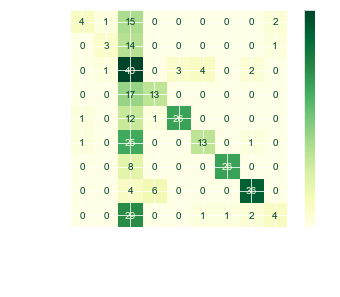

In [51]:
evaluate("-----Random forest with simple counts, 150 trees, max depth 1000) Evaluation-----",y_test,forest_150_1000_simple_predicted,mat_tags)
get_confused_samples(quotes,forest_150_1000_simple_predicted)

-----Random forest with TFIDF counts, 100 trees, max depth 200) Evaluation-----
Micro:
precision: 0.5741324921135647
recall: 0.5741324921135647
f1: 0.5741324921135647

Macro:
precision: 0.692851902401759
recall: 0.5298107035191433
f1: 0.5600062547393226

Accuracy: 0.5741324921135647

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 92 of 135 (68.14814814814815%)

Distribution of misclassified topics:
בלי           92
בריאות        14
רווחה          9
חינוך          6
כלכלי          6
קורונה         3
בטחון          3
בטחון פנים     1
נשים           1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
0,0,"בוקר טוב. היום ה-11 בפברואר 2018, כ""ו בשבט התש...",בריאות,בלי
6,6,"כן, אבל זה רק מעלה את השאלה האם בכלל החוק הזה ...",רווחה,בלי
13,13,ביום הזה כולנו עם המשפחה שנטבחה בחלמיש ואנחנו ...,בטחון,בלי
14,14,"מכובדיי, צוהריים טובים לכולם. אני מתנצל על האי...",כלכלי,בלי
16,16,אנחנו רוצים לשמוע את הממצאים הראשונים כתוצאה ש...,בטחון פנים,בלי
...,...,...,...,...
309,309,אהלן. אני שמח לפתוח את ישיבת ועדת המשנה של ועד...,בלי,חינוך
311,311,אנחנו עוברים לסעיף האחרון בסדר היום. על סדר הי...,בטחון,בלי
314,314,אנחנו רואים באמת שאין מספיק פתרונות לאוכלוסיות...,חינוך,בלי
315,315,"הבת, שמה לינדה, היא נפגעה, הייתה יומיים בטיפול...",בטחון פנים,רווחה


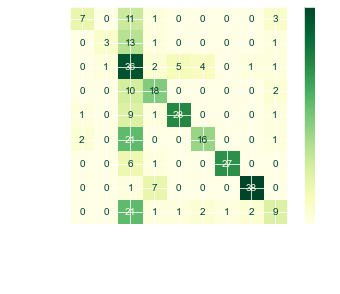

In [52]:
evaluate("-----Random forest with TFIDF counts, 100 trees, max depth 200) Evaluation-----",y_test,forest_100_200_tfidf_predicted,mat_tags)
get_confused_samples(quotes,forest_100_200_tfidf_predicted)

-----Random forest with TFIDF counts, 100 trees, max depth 1000) Evaluation-----
Micro:
precision: 0.5331230283911672
recall: 0.5331230283911672
f1: 0.5331230283911672

Macro:
precision: 0.6903227802911118
recall: 0.48522366588862753
f1: 0.5136127826866702

Accuracy: 0.5331230283911672

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 114 of 148 (77.02702702702703%)

Distribution of misclassified topics:
בלי           114
בריאות         11
חינוך           7
רווחה           5
כלכלי           3
קורונה          3
בטחון פנים      2
נשים            2
בטחון           1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
0,0,"בוקר טוב. היום ה-11 בפברואר 2018, כ""ו בשבט התש...",בריאות,רווחה
6,6,"כן, אבל זה רק מעלה את השאלה האם בכלל החוק הזה ...",רווחה,בלי
11,11,המתווים האלה שאפשרו כניסת תיירים בוטלו לאחרונה...,קורונה,בלי
13,13,ביום הזה כולנו עם המשפחה שנטבחה בחלמיש ואנחנו ...,בטחון,בלי
14,14,"מכובדיי, צוהריים טובים לכולם. אני מתנצל על האי...",כלכלי,בלי
...,...,...,...,...
309,309,אהלן. אני שמח לפתוח את ישיבת ועדת המשנה של ועד...,בלי,חינוך
311,311,אנחנו עוברים לסעיף האחרון בסדר היום. על סדר הי...,בטחון,בלי
314,314,אנחנו רואים באמת שאין מספיק פתרונות לאוכלוסיות...,חינוך,בלי
315,315,"הבת, שמה לינדה, היא נפגעה, הייתה יומיים בטיפול...",בטחון פנים,נשים


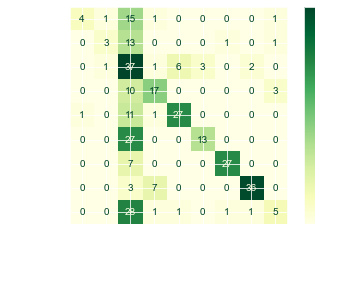

In [53]:
evaluate("-----Random forest with TFIDF counts, 100 trees, max depth 1000) Evaluation-----",y_test,forest_100_1000_tfidf_predicted,mat_tags)
get_confused_samples(quotes,forest_100_1000_tfidf_predicted)

## SVM

-----SVM with simple counts Evaluation-----
Micro:
precision: 0.43217665615141954
recall: 0.43217665615141954
f1: 0.4321766561514196

Macro:
precision: 0.5900014639145073
recall: 0.3565433464154692
f1: 0.3711627839510439

Accuracy: 0.43217665615141954

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 173 of 180 (96.11111111111111%)

Distribution of misclassified topics:
בלי       173
רווחה       2
בריאות      2
חינוך       2
כלכלי       1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
0,0,"בוקר טוב. היום ה-11 בפברואר 2018, כ""ו בשבט התש...",בריאות,בלי
6,6,"כן, אבל זה רק מעלה את השאלה האם בכלל החוק הזה ...",רווחה,בלי
8,8,"אני שמעתי פחות, דרך אגב, אני שמעתי 14% נשים, ב...",נשים,בלי
11,11,המתווים האלה שאפשרו כניסת תיירים בוטלו לאחרונה...,קורונה,רווחה
13,13,ביום הזה כולנו עם המשפחה שנטבחה בחלמיש ואנחנו ...,בטחון,בלי
...,...,...,...,...
309,309,אהלן. אני שמח לפתוח את ישיבת ועדת המשנה של ועד...,בלי,חינוך
311,311,אנחנו עוברים לסעיף האחרון בסדר היום. על סדר הי...,בטחון,בלי
314,314,אנחנו רואים באמת שאין מספיק פתרונות לאוכלוסיות...,חינוך,בלי
315,315,"הבת, שמה לינדה, היא נפגעה, הייתה יומיים בטיפול...",בטחון פנים,בלי


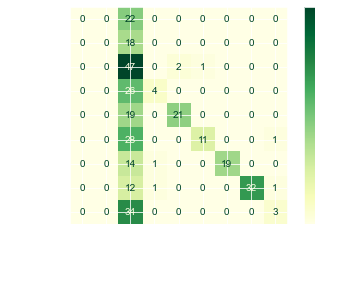

In [54]:
evaluate("-----SVM with simple counts Evaluation-----",y_test, svm_simple_predicted,mat_tags)
get_confused_samples(quotes,svm_simple_predicted)

-----SVM with TFIDF counts Evaluation-----
Micro:
precision: 0.45741324921135645
recall: 0.45741324921135645
f1: 0.4574132492113564

Macro:
precision: 0.6760354143040227
recall: 0.39143097914623914
f1: 0.42440206398539737

Accuracy: 0.45741324921135645

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 162 of 172 (94.18604651162791%)

Distribution of misclassified topics:
בלי           162
רווחה           3
חינוך           3
בריאות          2
בטחון פנים      1
כלכלי           1
Name: predicted, dtype: int64


,index,QuoteText,true,predicted
0,0,"בוקר טוב. היום ה-11 בפברואר 2018, כ""ו בשבט התש...",בריאות,רווחה
6,6,"כן, אבל זה רק מעלה את השאלה האם בכלל החוק הזה ...",רווחה,בלי
11,11,המתווים האלה שאפשרו כניסת תיירים בוטלו לאחרונה...,קורונה,בלי
13,13,ביום הזה כולנו עם המשפחה שנטבחה בחלמיש ואנחנו ...,בטחון,בלי
14,14,"מכובדיי, צוהריים טובים לכולם. אני מתנצל על האי...",כלכלי,בלי
...,...,...,...,...
309,309,אהלן. אני שמח לפתוח את ישיבת ועדת המשנה של ועד...,בלי,חינוך
311,311,אנחנו עוברים לסעיף האחרון בסדר היום. על סדר הי...,בטחון,בלי
314,314,אנחנו רואים באמת שאין מספיק פתרונות לאוכלוסיות...,חינוך,בלי
315,315,"הבת, שמה לינדה, היא נפגעה, הייתה יומיים בטיפול...",בטחון פנים,בלי


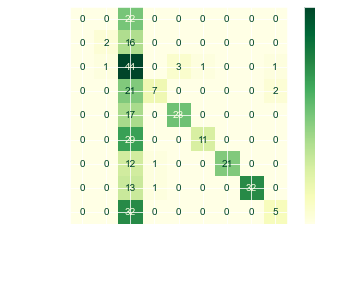

In [55]:
evaluate("-----SVM with TFIDF counts Evaluation-----",y_test, svm_tfidf_predicted,mat_tags)
get_confused_samples(quotes,svm_tfidf_predicted)